# Week 8: Social media sentiment analysis

This final week we are analyzing our social media data with sentiment analysis. There are a few ways to perform sentiment analysis:

- use a dictionary lookup: words have corresponding sentiment values we use to calculate overall sentiment for a text chunk
    - scores can range from -1 to +1 or another range
    - we can add other rules for negations (e.g. the word 'not' flips the sign of the score for the next word)
- use a machine learning model; train a classifier on labeled data
    - label can be -1, 0, or +1 for negative, neutral, or positive
    
We will start with a demonstration of the keyword lookup method and also cover the machine learning method.

## Load data

First we need to load our data from our SQLite database we saved last week:

In [1]:
import sqlite3
import pandas as pd

con = sqlite3.connect('co_reddit.sqlite')
df = pd.read_sql_query('SELECT * from posts;', con)
con.close()
df

,index,title,link,author,n_comments,score,text,id
0,0,"Red Rocks, 1974 John Denver concert",/r/Colorado/comments/mug406/red_rocks_1974_joh...,Mellotime,1,28,,mug406
1,1,Hiking the Royal Gorge in a spring snowstorm,/r/Colorado/comments/muffdl/hiking_the_royal_g...,TaipeiPersonality_,1,19,,muffdl
2,2,Rocky Mountain National Park this weekend!,/r/Colorado/comments/mufe4j/rocky_mountain_nat...,TaipeiPersonality_,2,19,,mufe4j
3,3,Milky way at Loveland Pass last weekend,/r/Colorado/comments/mud617/milky_way_at_lovel...,Sutitan,35,692,,mud617
4,4,Weminuche Wilderness,/r/Colorado/comments/mu835a/weminuche_wilderness/,finerminer17,13,189,,mu835a
...,...,...,...,...,...,...,...,...
912,912,Hoarfrost on one of my sundials this brisk mor...,/r/Colorado/comments/kcnpj5/hoarfrost_on_one_o...,IronRainForge,5,78,,kcnpj5
913,913,The Stanley Hotel after some snow,/r/Colorado/comments/kclire/the_stanley_hotel_...,TFG4,9,251,,kclire
914,914,The stanley hotel in Estes in October,/r/Colorado/comments/kclfwi/the_stanley_hotel_...,TFG4,1,44,,kclfwi
915,915,Picture my dad took - Sawatch Range just SW of...,/r/Colorado/comments/kckwut/picture_my_dad_too...,theredcameron,6,95,,kckwut


Since most of our text is missing for this subreddit, we'll just use the title of the posts. However, if you have text from each post or comments for each post, you could combine those with the title.

# Keyword sentiment 

We will start with a keyword sentiment analysis technique. Let's first load a dictionary of words and sentiment values:

In [2]:
sentiment_df = pd.read_csv('AFINN-en-165.txt', sep='\t', names=['word', 'score'], index_col='word')

In [3]:
sentiment_df

,score
word,
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
...,...
yucky,-2
yummy,3
zealot,-2


In [4]:
sentiment_dict = sentiment_df.to_dict()['score']

Here, we load the data into a dataframe. There is no header so we provide the column names with the `names` argument. Then we set the word as the index, which helps with the next step where we convert the dataframe to a dictionary. This has the column names as keys, then the values are dictionaries with the index value as keys and the column values as values. So we get a dictionary like this:

```python
{'abandon': -2,
 'abandoned': -2,
 'abandons': -2,
 'abducted': -2,
 ...
}
```

Now we can get the average sentiment for each string we have in our original dataframe, which is the title of each post. We get the scores for each word and take the average for each title:

In [5]:
import numpy as np

title_sentiments = []
for title in df['title']:
    words = title.lower().split()
    this_titles_sentiments = []
    for w in words:
        if w in sentiment_dict.keys():
            this_titles_sentiments.append(sentiment_dict[w])
        else:
            this_titles_sentiments.append(0)
            
    
    title_sentiments.append(np.mean(this_titles_sentiments))

In [6]:
df['keyword_sentiment'] = title_sentiments

<AxesSubplot:ylabel='Frequency'>

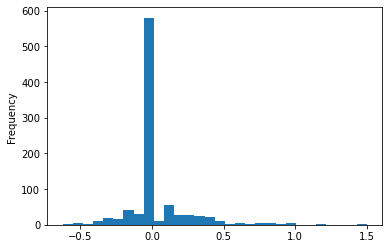

In [7]:
df['keyword_sentiment'].plot.hist(bins=30)

In [8]:
df['keyword_sentiment'].mean()

0.0412800450004885

We can easily create a new column in our original dataframe with sentiments and then use it to create plots. Since this lookup dictionary method doesn't have a lot of words,  we get a lot of 0 scores. These don't necessarily mean the sentiments are neutral, but may mean that no words were in the lookup dictionary. Overall, we can see the sentiments trend towards a positive value.

A more interesting result might be had by looking at the sentiment for comments on posts. Last week in the advanced section we collected comments on posts. We can perform a similar analysis as above on the comments to see what the sentiment is on each post. Then we can combine the posts and comments dataframes to see the titles of the posts with some of the most positive and negative sentiments to help us understand what some of the most positive and negative topics are in the subreddit. This is left as an optional challenge for you in the assignment.

Let's look at some of the top and bottom sentiment posts:

In [9]:
df.sort_values(by='keyword_sentiment')[['title', 'keyword_sentiment']]

,title,keyword_sentiment
181,Colorado judge strikes down Boulder’s assault ...,-0.625000
508,Arrests made in deadly Green Valley Ranch arson,-0.625000
635,"7 Injured, 1 Killed In Berthoud Pass Head-On C...",-0.555556
52,"9News, Parent Company Accused of Racist Behavi...",-0.500000
105,Animal cruelty initiative irks Colorado ranchers,-0.500000
...,...,...
780,Good morning Colorado!,1.000000
860,Colorados beautiful nature,1.000000
380,Great White Buffalo,1.000000
738,Love the beautiful snowy Rockies!,1.200000


In [10]:
# full titles of the bottom 10 sentiments
df.sort_values(by='keyword_sentiment')['title'].to_list()[:10]

['Colorado judge strikes down Boulder’s assault weapons ban',
 'Arrests made in deadly Green Valley Ranch arson',
 '7 Injured, 1 Killed In Berthoud Pass Head-On Crash',
 '9News, Parent Company Accused of Racist Behavior in Federal Filing',
 'Animal cruelty initiative irks Colorado ranchers',
 'Muslim groups mourn and raise money for Colorado shooting victims',
 'MISSING PERSON— Marlena Mizell',
 'Dismal snow at Loveland',
 'Three backcountry skiers killed in Colorado avalanche',
 'Parker mayor denies knowledge of QAnon and conspiracy theories that he tweeted.']

In [11]:
# full titles of the top 10 sentiments
df.sort_values(by='keyword_sentiment', ascending=False)['title'].to_list()[:10]

['Beautiful Ouray',
 'Love the beautiful snowy Rockies!',
 'Mt. Champion',
 'Colorados beautiful nature',
 'Great White Buffalo',
 'Glorious morning',
 'Hello Beautiful 💕',
 'Good morning Colorado!',
 'Super rad, this guy wins Colorado today. 🤘🏼',
 'The beautiful Great Sand Dunes National Park']

# Using Python packages for sentiment analysis

There are a few Python packages that use rule-based and keyword-based sentiment analysis. We will look at VADER and textblob here, although there are probably more. We need to install these first: `conda install -c conda-forge textblob vadersentiment -y`. Another option we won't cover here is the `flair` package. We can use textblob and vader like so:

In [13]:
from textblob import TextBlob

tb = TextBlob("April snowstorms make for some beautiful pictures...")
tb.sentiment

Sentiment(polarity=0.85, subjectivity=1.0)

Textblob requires us to use their TextBlob class on a string. Then we can get the sentiment score. It gives us polarity (-1 to =1) and subjectivite (0 to 1, objective to subjective). We can see this sentence is rated fully subjective and has a positive sentiment, which makes sense. We can apply it to the whole dataframe like so:

In [14]:
def get_tb_sentiment(text):
    tb = TextBlob(text)
    return tb.sentiment[0]

df['tb_sentiment'] = df['title'].apply(get_tb_sentiment)

Because we need to do a few steps to get the polarity (sentiment) score, we wrote a short function to do it. Then we use the pandas `apply` function to apply this to the whole dataframe.

Note: If you have a lot of data and want to speed this up, look at the `swifter` package for parallelizing the `apply` function.

Now we can look at the distribution of these sentiments:

<AxesSubplot:ylabel='Frequency'>

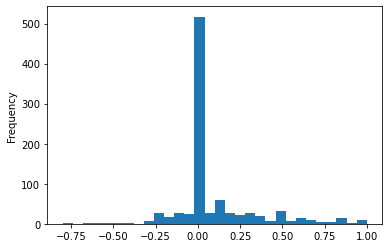

In [15]:
df['tb_sentiment'].plot.hist(bins=30)

In [16]:
df['tb_sentiment'].mean()

0.09054171818604066

We can see the distribution looks similar but is more spread out than our AFINN method. textblob has more words in its lookup dictionary than the AFINN dictionary we used.

VADER is similar to use:

In [17]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
analyzer.polarity_scores("April snowstorms make for some beautiful pictures...")

{'neg': 0.0, 'neu': 0.606, 'pos': 0.394, 'compound': 0.5994}

In [18]:
analyzer.polarity_scores("April snowstorms make for some beautiful pictures...")['compound']

0.5994

Vader provides a breakdown of the negative, positive, an neutral scores, as well as an overall score called 'compound'. We can simply use the 'compound' score as our overall sentiment score.

# Optional advanced section

## Word vectors

Word vectors allow us to do more advanced NLP, like topic modeling, ML, and more. These might also be called text embeddings or word embeddings. We can train our own models to create these, or use pre-built vectors like GLoVe and Word2Vec. You can read more about the different ways how word embeddings/vectors are created [here](https://machinelearningmastery.com/what-are-word-embeddings/).

One of the easier ways to extract word embeddings is with the SpaCy NLP Python package. An example is [here](https://spacy.io/usage/embeddings-transformers) in the documentation (there is also a nice free course on SpaCy by one of the creators [here](https://course.spacy.io/en/)).

## Using machine learning for sentiment analysis

If you are being very advanced, you might use word embeddings to train a ML model or topic model on the data. However, you can also do it with simpler features, like word counts (or a version of normalized word counts called TFIDF). The NLTK documentation shows an example of how to train a ML model for sentiment analysis [here](http://www.nltk.org/howto/sentiment.html). Like all ML models, the quality of predictions depends on the training data. So ideally, we would want similar training data to what we will use our model on. Many examples will use movie reviews as their training data, and so may not work well on social media data.

## Topic modeling

One fun way to analyze text is with topic modeling. This groups text into topics, and we can extract the top words out of these topics. In this way, we can see the general themes of what people are talking about. One package for doing this in Python is Gensim, and there are a few tutorials out there, such as [this one](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), showing how to perform topic modeling with Gensim. In our case, it would be interesting to look at the main topics of a subreddit to see what people are talking about.